In [1]:
import sys
import os
import itertools
import dask
import dask.array as da
import dask.optimization as do
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import astropy.units as un

from dask.diagnostics import ProgressBar
from pathlib import Path

In [2]:
# pyralysis
from pyralysis.io import DaskMS, FITS
from pyralysis.io.zarr import ZarrArray
from pyralysis.reconstruction import Image
from pyralysis.reconstruction.mask import Mask
from pyralysis.convolution import Bicubic, PSWF1, Spline, Pillbox, Gaussian, GaussianSinc, Sinc
from pyralysis.optimization.fi import Chi2, L1Norm, Entropy
from pyralysis.optimization import ObjectiveFunction
from pyralysis.optimization.projection import LessThan
from pyralysis.optimization.linesearch import Brent
from pyralysis.optimization.optimizer import PolakRibiere, HagerZhang, LBFGS
from pyralysis.convolution import PSWF1, Gaussian
from pyralysis.estimators import Degridding, BilinearInterpolation, NearestNeighbor
from pyralysis.transformers import Gridder, HermitianSymmetry, DirtyMapper, UVTaper, ModelVisibilities
from pyralysis.transformers.weighting_schemes import Uniform, Robust

In [3]:
from dask.distributed import Client, progress

In [4]:
import psutil

In [5]:
n_workers = psutil.cpu_count(logical=False) - 1

In [ ]:
client = Client(n_workers=n_workers, threads_per_worker=2)
client

<Client: 'tcp://127.0.0.1:42739' processes=7 threads=14, memory=62.71 GiB>

2025-02-12 12:16:21,898 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,905 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,906 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,915 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,917 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,944 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:21,947 - distributed.nanny - WARNING - Restarting worker
2025-02-12 12:16:31,750 - distributed.scheduler - WARNING - Detected different `run_spec` for key ('unique-aggregate-unique_internal-4907343379799567a81e153bdcdaeab7', 0) between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/d

In [7]:
client.restart()

In [8]:
m87 = str(Path(os.path.abspath("__file__")).parents[1]) + "/datasets/M87/"
selfcalband9 = str(Path(os.path.abspath("__file__")).parents[1]) + "/datasets/selfcalband9/"
freq78 = str(Path(os.path.abspath("__file__")).parents[1]) + "/datasets/FREQ78/"
co65 = str(Path(os.path.abspath("__file__")).parents[1]) + "/datasets/co65/"
antennae = str(Path(os.path.abspath("__file__")).parents[1]) + "/datasets/antennae/"

file_dict = {
    0: m87 + 'SR1_M87_2017_101_hi_hops_netcal_StokesI.selfcal.LLRR.ms',
    1: m87 + 'SR1_M87_2017_101_lo_hops_netcal_StokesI.selfcal.LLRR.ms',
    2: m87 + 'SR1_M87_2017_101_hilo_hops_netcal_StokesI.selfcal.final.ms',
    3: selfcalband9 + 'hd142_b9cont_self_tav.ms',
    4: freq78 + "FREQ78.ms",
    5: co65 + "co65.ms",
    6: antennae + "all_fields.ms",
}

file_dataset = file_dict[5]
file_dataset

'/home/miguel/Documents/pyralysis/datasets/co65/co65.ms'

In [9]:
ds = DaskMS(input_name=file_dataset)

In [10]:
dataset = ds.read(filter_flag_column=False, calculate_psf=False)  #

# Objects to test

In [11]:
imsize = 128
dx = dataset.theo_resolution / 7
hermitian_symmetry = False
padding_factor = 1.
cs = dx * 2.  #0.0031 * un.arcsec

In [12]:
if hermitian_symmetry:
    h_symmetry = HermitianSymmetry(input_data=dataset)
    h_symmetry.apply()

In [13]:
oversampling_factor = 3

size = 3

spline_kernel = Spline(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
bicubic_kernel = Bicubic(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
pswf1_kernel = PSWF1(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
gaussian_kernel = Gaussian(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
gaussian_sinc_kernel = GaussianSinc(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
sinc_kernel = Sinc(size=size, cellsize=cs, oversampling_factor=oversampling_factor)
pillbox_kernel = Pillbox(size=size, cellsize=cs, oversampling_factor=oversampling_factor)

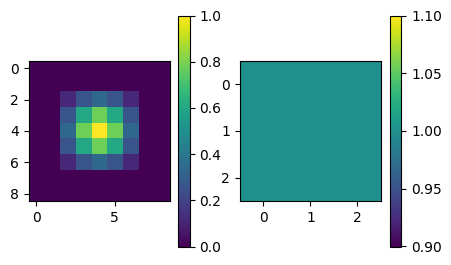

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))

p1 = axes[0].imshow(bicubic_kernel.kernel((size, size)).real)
p2 = axes[1].imshow(bicubic_kernel.gcf((size, size)))

plt.colorbar(p1, ax=axes[0])
plt.colorbar(p2, ax=axes[1])

## Image

In [15]:
# rechunk data image
# The xarray code has a bug since it won't chunk the data even if you explicitly do it
X, Y = np.mgrid[0:imsize, 0:imsize]
chunks = (imsize // n_workers, imsize // n_workers)
image_start = da.zeros((imsize, imsize), chunks=chunks, dtype=np.float32)
image = Image(
    data=xr.DataArray(
        data=image_start,
        dims=["x", "y"],
        coords=dict(X=(["x", "y"], Y), Y=(["x", "y"], X)),
    ),
    cellsize=cs
)
image.data = image.data.chunk(chunks)

/tmp/ipykernel_54977/1381120288.py:14: DeprecationWarning: Supplying chunks as dimension-order tuples is deprecated. It will raise an error in the future. Instead use a dict with dimension names as keys.
  image.data = image.data.chunk(chunks)


## Mask

In [16]:
freq = [dataset.spws.min_nu.value]
pb = dataset.antenna.primary_beam
pointings = dataset.field.phase_direction_cosines[0:2]
pointings_cartesian = (pointings / cs).value
beams = da.array(
    [
        pb.beam(
            frequency=freq,
            imsize=image.data.shape,
            cellsize=cs,
            antenna=np.array([0]),  # Token antenna, for default mask
            x_0=pointings[0][i].value,
            y_0=pointings[1][i].value,
            imcenter=(image.center_pixel[0], image.center_pixel[1])
        ) for i in range(pointings.shape[-1])
    ]
)
beam = da.sum(beams, axis=(0, 1, 2))
normalized_beam = beam / da.max(beam)

dims = ["x", "y"]
inverse_beam = (1 / normalized_beam).compute()  # The same as squeeze

th = np.percentile(inverse_beam, 20)
print(th)

1.1760929822921753


In [17]:
x_pix = np.arange(0, imsize)
y_pix = np.arange(0, imsize)
Z = np.zeros((imsize, imsize))
# Creating 2-D grid of features
X, Y = np.meshgrid(x_pix, y_pix)
Z[inverse_beam <= th] = 1

Text(0.5, 1.0, 'Mask size')

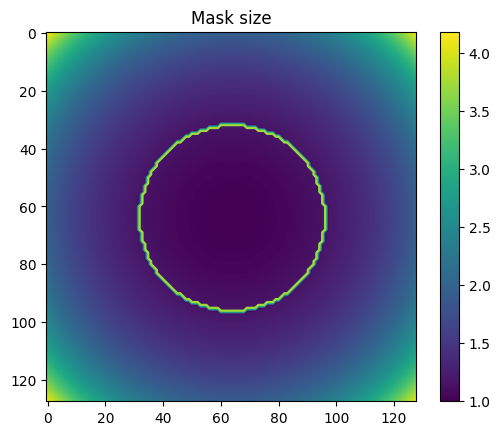

In [18]:
plt.imshow(inverse_beam)
plt.colorbar()
plt.contour(X, Y, Z)
plt.title("Mask size")

In [19]:
mask = Mask(dataset=dataset, imsize=image.data.shape, threshold=th, cellsize=cs)

## ModelVisibility

In [ ]:
mv = NearestNeighbor(
    input_data=dataset,
    image=image,
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor
)
"""
mv = Degridding(
    input_data=dataset,
    image=image,
    hermitian_symmetry=hermitian_symmetry,
    padding_factor=padding_factor,
    ckernel_object=bicubic_kernel
)
"""

'\nmv = Degridding(\n    input_data=dataset,\n    image=image,\n    hermitian_symmetry=hermitian_symmetry,\n    padding_factor=padding_factor,\n    ckernel_object=bicubic_kernel\n)\n'

## ObjectiveFunction

In [21]:
fi_list = [Chi2(model_visibility=mv, normalize=True)]
of = ObjectiveFunction(fi_list=fi_list, image=image, persist_gradient=True)

## LineSearch

In [22]:
ls = Brent(objective_function=of)

In [23]:
ioh = ZarrArray()

In [24]:
#proj = None
proj = LessThan(compared_value=0., replacement_value=0.)

## Optimizer

In [25]:
niter = 10
optim = HagerZhang(
    image=image,
    objective_function=of,
    linesearch=ls,
    mask=mask,
    max_iter=niter,
    io_handler=ioh,
    projection=proj,
)

# Optimize

In [ ]:
res = optim.optimize(verbose=True, partial_image=True)

Starting Hager-Zhang method (Conj. Grad.)
Starting function value = 0.9442
Iteration 1
Alpha value = 2.237437e+01
Function value = 0.9399
Time: 51.5297 seconds
Iteration 2
Alpha value = 1.680697e+01
Function value = 0.9395
Time: 45.4263 seconds
Iteration 3
Alpha value = 1.871047e+01
Function value = 0.9391
Time: 45.2117 seconds
Iteration 4
Alpha value = 1.120670e+01
Function value = 0.9389
Time: 35.6844 seconds
Iteration 5
Alpha value = 7.812068e+00
Function value = 0.9388
Time: 39.6199 seconds
Iteration 6


KeyboardInterrupt: 

2025-02-12 12:20:18,272 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/home/miguel/micromamba/envs/pyralysis-env/lib/python3.12/asyncio/runners.py", line 118, in run
    return self._loop.run_until_complete(task)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/miguel/micromamba/envs/pyralysis-env/lib/python3.12/asyncio/base_events.py", line 686, in run_until_complete
    return future.result()
           ^^^^^^^^^^^^^^^
  File "/home/miguel/micromamba/envs/pyralysis-env/lib/python3.12/site-packages/distributed/nanny.py", line 977, in run
    await worker.finished()
2025-02-12 12:20:18,273 - distributed.nanny - ERROR - Worker process died unexpectedly
  File "/home/miguel/micromamba/envs/pyralysis-env/lib/python3.12/site-packages/distributed/core.py", line 491, in finished
    await self._event_finished.wait()
  File "/home/miguel/micromamba/envs/pyralysis-env/lib/python3.1

In [ ]:
with ProgressBar():
    res_mem = res.data.compute()

In [ ]:
plt.imshow(res_mem, origin="lower")
plt.colorbar()
plt.show()

In [ ]:
import zarr

for i in range(1, niter + 1):
    fn = f"partial_{i}.fits"
    a = zarr.load(fn)
    plt.imshow(a, origin="lower")
    plt.colorbar()
    plt.show()

In [ ]:
client.shutdown()

In [ ]:
client.status